<a href="https://colab.research.google.com/github/joellee13lh/GEOG5990M_final/blob/main/GEOG5990M_Final_Project_201896942.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5990M Final Assignment

Student ID number: 201896942

This research aims to explore the relationship between house prices in the Greater Manchester metropolitan area and the transportation accessibility of each property location. By analyzing open data sources and employing both non-spatial and spatial visualization techniques, this study seeks to provide valuable insights for relevant stakeholders.

In [ ]:
# import required packages
# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data manipulation
import pandas as pd
import numpy as np

# import any further required packages
!pip install contextily
!pip install geoplot

import geopandas as gpd
import pyproj
import contextily as ctx

import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

First, load the house price data

Data source: Statistical data set - Price Paid Data

https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#march-2025-data-current-month

This dataset contains records of all house transactions in England from January to March 2025


Load the data and examine the data fields

In [3]:
!pip install gdown -q

import os
import gdown
import pandas as pd

# 创建数据目录
os.makedirs('./data', exist_ok=True)

# 从共享链接下载房价数据文件
file_id = "1pwLMkWIKY2NeoM-r1l0LILYsHgjvki_M"  # 从您的Google Drive链接中提取
output_path = "./data/pp-2025.csv"

if not os.path.exists(output_path):
    print(f"Downloading housing price data to {output_path}...")
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)
else:
    print(f"File already exists at {output_path}")

# 然后使用本地路径读取文件
hpall = pd.read_csv('./data/pp-2025.csv')
hpall.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Transaction unique identifier   Price Date of Transfer  Postcode  \
0  {31C68072-988E-FEE3-E063-4804A8C04F37}  320000   2025/2/28 0:00  KT20 5SJ   
1  {31C68072-988F-FEE3-E063-4804A8C04F37}  423500   2025/2/14 0:00   RH1 3LS   
2  {31C68072-9891-FEE3-E063-4804A8C04F37}  525000   2025/2/13 0:00  GU18 5AA   
3  {31C68072-9892-FEE3-E063-4804A8C04F37}  845000   2025/3/24 0:00   RH1 4JA   
4  {31C68072-9893-FEE3-E063-4804A8C04F37}  225000   2025/2/24 0:00  GU15 2EH   

  Property Type Old/New Duration               PAON    SAON  \
0             F       N        L                 21     NaN   
1             S       N        F                 36     NaN   
2             D       N        F                 20     NaN   
3             D       N        F     NUTFIELD COURT       2   
4             F       N        L  BENTLEY COURT, 33  FLAT 3   

              Street  Locality   Town/City              District  County  \
0  CORNER FARM CLOSE       NaN    TADWORTH  REIGATE AND BANSTEAD  SURREY   
1        ALBURY ROAD  MERSTHAM     REDHILL  REIGATE AND BANSTEAD  SURREY   
2     CONISTON COURT       NaN  LIGHTWATER          SURREY HEATH  SURREY   
3        CHURCH HILL  NUTFIELD     REDHILL             TANDRIDGE  SURREY   
4  UPPER GORDON ROAD       NaN   CAMBERLEY          SURREY HEATH  SURREY   

  PPD Category Type Record Status  
0                 A             A  
1                 A             A  
2                 A             A  
3                 A             A  
4                 A             A

It can be observed that there is a significant amount of redundant information for this research project.

The analysis requires filtering the housing transaction data to include only those within Manchester using the county field. Then, extraneous fields should be removed, retaining only house prices, postcodes, and selected property parameters. Notably, the property transaction data does not include spatial information. The only information related to accurate geographical locations is the postcode. Therefore, subsequent steps will involve using postcode data to add spatial attributes to the house price information.

In [4]:
hpall.info()
hpall.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106006 entries, 0 to 106005
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Transaction unique identifier  106006 non-null  object
 1   Price                          106006 non-null  int64 
 2   Date of Transfer               106006 non-null  object
 3   Postcode                       105915 non-null  object
 4   Property Type                  106006 non-null  object
 5   Old/New                        106006 non-null  object
 6   Duration                       106006 non-null  object
 7   PAON                           106006 non-null  object
 8   SAON                           11346 non-null   object
 9   Street                         104579 non-null  object
 10  Locality                       39957 non-null   object
 11  Town/City                      106006 non-null  object
 12  District                       106006 non-nu

Price
count  1.060060e+05
mean   3.507790e+05
std    8.024717e+05
min    1.000000e+02
25%    1.880000e+05
50%    2.850000e+05
75%    4.200000e+05
max    1.514200e+08

Postcode Geographical Data Points

Ordnance Survey

https://osdatahub.os.uk/downloads/open/CodePointOpen

The method for calculating postcode centroids in the Ordnance Survey's Code-Point Open product for postcodes with a Positional Quality Indicator (PQI) of 10 determines the centroid by calculating the average coordinates of all addresses within the postcode unit, then selecting the coordinates of the actual address closest to this average position <a href="https://www.whatdotheyknow.com/request/algorithm_for_computing_postcode">[1]</a>.

This method has been widely applied and validated in health geography and spatial epidemiology research. Studies by Henry et al. demonstrate that the population-weighted centroid method provides higher matching rates across areas of varying population density compared to the geographical centroid method <a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC2266732/">[2]</a>.

Therefore, using postcode centroids as location data for houses is more justified and conducive to this research than directly using the geometric centers of postcode areas.




In [5]:
# Load postcode position data
pcptall = gpd.read_file('/content/drive/MyDrive/Python_final/codepo_gb.gpkg')

# Read Shapefile
lsoa_all = gpd.read_file('/content/drive/MyDrive/Python_final/BoundaryData/england_lsoa_2021.shp')

In [6]:
# Define all area names in Greater Manchester and filter
gm_areas = ['Manchester', 'Salford', 'Bolton', 'Bury', 'Oldham',
            'Rochdale', 'Stockport', 'Tameside', 'Trafford', 'Wigan']
gm_lsoa = lsoa_all[lsoa_all['lsoa21nm'].str.startswith(tuple(gm_areas))]

In [7]:
pcptall.head()

postcode  positional_quality_indicator country_code nhs_regional_ha_code  \
0  AL1 1AG                            10    E92000001            E19000001   
1  AL1 1AJ                            10    E92000001            E19000001   
2  AL1 1AR                            10    E92000001            E19000001   
3  AL1 1AS                            10    E92000001            E19000001   
4  AL1 1AT                            10    E92000001            E19000001   

  nhs_ha_code admin_county_code admin_district_code admin_ward_code  \
0   E18000006         E10000015           E07000240       E05013963   
1   E18000006         E10000015           E07000240       E05013963   
2   E18000006         E10000015           E07000240       E05013951   
3   E18000006         E10000015           E07000240       E05013964   
4   E18000006         E10000015           E07000240       E05013951   

                geometry  
0  POINT (515487 206498)  
1  POINT (515491 206410)  
2  POINT (516270 205897)  
3  POINT (515005 206908)  
4  POINT (516131 206148)

In [9]:
gm_lsoa.head()

lsoa21cd     lsoa21nm                                          label  \
0   E01004785  Bolton 006B  E92000001E12000002E08000001E02000989E01004785   
20  E01005443  Oldham 003B  E92000001E12000002E08000004E02001100E01005443   
21  E01006380   Wigan 029D  E92000001E12000002E08000010E02001315E01006380   
22  E01005434  Oldham 024B  E92000001E12000002E08000004E02001121E01005434   
24  E01005007    Bury 019D  E92000001E12000002E08000002E02001037E01005007   

           name                                           geometry  
0   Bolton 006B  POLYGON ((374304.608 411531.913, 374306.625 41...  
20  Oldham 003B  POLYGON ((394102.25 411199.249, 394108.5 41119...  
21   Wigan 029D  POLYGON ((371555.967 402040.5, 371552.615 4020...  
22  Oldham 024B  POLYGON ((392889.653 405054.093, 392893.478 40...  
24    Bury 019D  POLYGON ((380549.366 406758.315, 380543.792 40...

Spatially join each postcode point to its corresponding LSOA, in preparation for potential spatial visualization.

In [8]:
# Perform geospatial join between LSOA data and postcode points based on geographic location
print(f"postcode CRS: {pcptall.crs}")
print(f"LSOA CRS: {gm_lsoa.crs}")

postcode_simple = pcptall[['postcode', 'geometry', 'positional_quality_indicator']].copy()
lsoa_simple = gm_lsoa[['lsoa21cd', 'lsoa21nm', 'geometry']].copy()
pc_man = gpd.sjoin(
    postcode_simple,
    lsoa_simple,
    how="inner",
    predicate="intersects"
)

pc_man.head()

postcode CRS: EPSG:27700
LSOA CRS: EPSG:27700


postcode               geometry  positional_quality_indicator  \
113456  BL0 0AA  POINT (379448 416851)                            10   
113457  BL0 0AB  POINT (379442 416877)                            10   
113458  BL0 0AD  POINT (379389 417007)                            10   
113460  BL0 0AG  POINT (379627 416803)                            10   
113461  BL0 0AH  POINT (379409 417016)                            10   

        index_right   lsoa21cd   lsoa21nm  
113456         3636  E01005014  Bury 001A  
113457         3636  E01005014  Bury 001A  
113458         3636  E01005014  Bury 001A  
113460         3764  E01005017  Bury 001D  
113461         3636  E01005014  Bury 001A

In [9]:
# Convert postcode point data to GeoDataFrame
postcode_gdf = gpd.GeoDataFrame(pc_man, geometry='geometry')
postcode_gdf['postcode_clean'] = postcode_gdf['postcode'].str.replace(' ', '')
hpall['postcode_clean'] = hpall['Postcode'].str.replace(' ', '')
if 'geometry' in hpall.columns:
    hpall = hpall.rename(columns={'geometry': 'geometry_original'})

# Perform the merge
merged_data = pd.merge(
    hpall,
    postcode_gdf[['postcode_clean', 'geometry', 'lsoa21nm', 'lsoa21cd']],
    on='postcode_clean',
    how='left'
)

merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
hp_man = merged_data[merged_data.geometry.notna()].copy()
hp_man.info()
hp_man.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4566 entries, 2741 to 104129
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Transaction unique identifier  4566 non-null   object  
 1   Price                          4566 non-null   int64   
 2   Date of Transfer               4566 non-null   object  
 3   Postcode                       4566 non-null   object  
 4   Property Type                  4566 non-null   object  
 5   Old/New                        4566 non-null   object  
 6   Duration                       4566 non-null   object  
 7   PAON                           4566 non-null   object  
 8   SAON                           468 non-null    object  
 9   Street                         4566 non-null   object  
 10  Locality                       2124 non-null   object  
 11  Town/City                      4566 non-null   object  
 12  District                  

Transaction unique identifier   Price Date of Transfer  \
2741  {31C68072-35D3-FEE3-E063-4804A8C04F37}  240000   2025/2/28 0:00   
2754  {31C68072-35E4-FEE3-E063-4804A8C04F37}  224550   2025/2/14 0:00   
3129  {31C68072-32D8-FEE3-E063-4804A8C04F37}  138000   2025/3/24 0:00   
3130  {31C68072-32DA-FEE3-E063-4804A8C04F37}  244999   2025/2/28 0:00   
3132  {31C68072-32DC-FEE3-E063-4804A8C04F37}   51000   2025/2/13 0:00   

      Postcode Property Type Old/New Duration  PAON SAON              Street  \
2741   M19 3HU             T       N        F     2  NaN     FAIRBOURNE ROAD   
2754    M6 7WG             T       N        F    10  NaN    STAPLETON STREET   
3129  OL11 4NA             T       N        L    19  NaN  WESTMINSTER STREET   
3130   BL3 4RT             D       N        L     8  NaN    CHESTERTON DRIVE   
3132   M43 7AA             F       N        F  154A  NaN       MARKET STREET   

       Locality   Town/City    District              County PPD Category Type  \
2741        NaN  MANCHESTER  MANCHESTER  GREATER MANCHESTER                 A   
2754        NaN     SALFORD     SALFORD  GREATER MANCHESTER                 A   
3129        NaN    ROCHDALE    ROCHDALE  GREATER MANCHESTER                 A   
3130        NaN      BOLTON      BOLTON  GREATER MANCHESTER                 A   
3132  DROYLSDEN  MANCHESTER    TAMESIDE  GREATER MANCHESTER                 A   

     Record Status postcode_clean               geometry         lsoa21nm  \
2741             A         M193HU  POINT (388204 394214)  Manchester 064A   
2754             A          M67WG  POINT (379402 400496)     Salford 018A   
3129             A        OL114NA  POINT (388769 412084)    Rochdale 010A   
3130             A         BL34RT  POINT (368276 408365)      Bolton 020A   
3132             A         M437AA  POINT (390483 398186)    Tameside 010E   

       lsoa21cd  
2741  E01005200  
2754  E01005622  
3129  E01005472  
3130  E01004835  
3132  E01006000

In [10]:
# Remove redundant fields
hp_man = hp_man.drop(['Transaction unique identifier', 'Date of Transfer', 'PAON', 'SAON', 'Locality', 'Street', 'PPD Category Type', 'Record Status', 'postcode_clean'], axis=1)
hp_man.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4566 entries, 2741 to 104129
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Price          4566 non-null   int64   
 1   Postcode       4566 non-null   object  
 2   Property Type  4566 non-null   object  
 3   Old/New        4566 non-null   object  
 4   Duration       4566 non-null   object  
 5   Town/City      4566 non-null   object  
 6   District       4566 non-null   object  
 7   County         4566 non-null   object  
 8   geometry       4566 non-null   geometry
 9   lsoa21nm       4566 non-null   object  
 10  lsoa21cd       4566 non-null   object  
dtypes: geometry(1), int64(1), object(9)
memory usage: 557.1+ KB


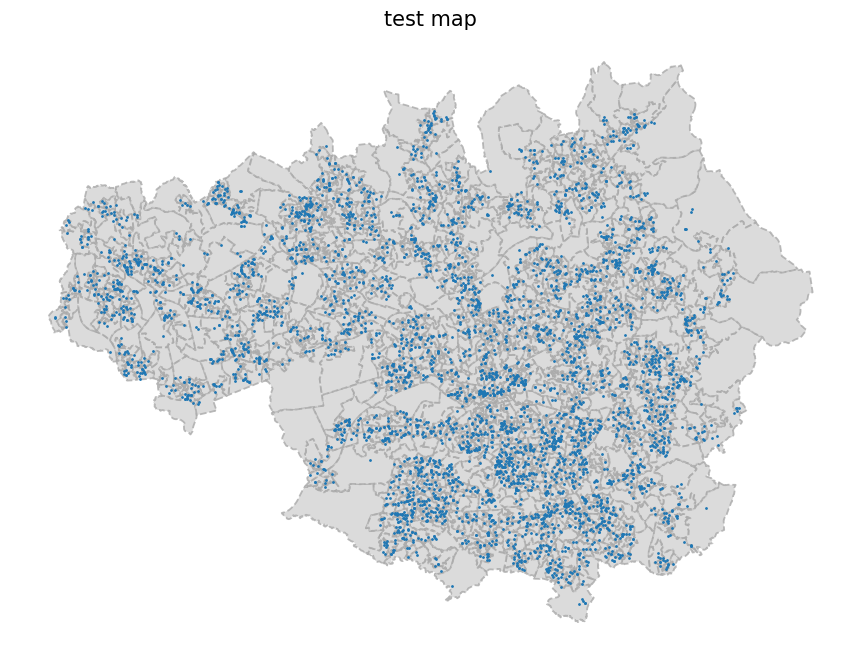

In [11]:
# House price data test visualization
f, ax = plt.subplots(1, figsize=(16, 8))
base = gm_lsoa.plot(ax=ax, facecolor='lightgrey', alpha=0.8,
                   edgecolor='darkgrey',
                   linewidth=1.3,
                   linestyle='dashed')
hp_man.plot(ax=base,
           markersize=1,
           legend=False)
ax.set_axis_off()
ax.set_title('test map', fontsize=15)
plt.show()

Based on the visualization results, it can be verified that the LSOA boundaries for Manchester have been correctly clipped, and the house price data points are evenly distributed within the Manchester area. At this stage, the geographical location data for houses and the corresponding house price data have been fully prepared, and the LSOA boundaries for Manchester have been completely processed.

The next step is to process the bus stop data.

In [12]:
# Import bus stop data
pbtsp_all = pd.read_csv('/content/drive/MyDrive/Python_final/Stops.csv')
pbtsp_all.info()

<ipython-input-12-88496a597dbe>:2: DtypeWarning: Columns (1,2,6,8,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  pbtsp_all = pd.read_csv('/content/drive/MyDrive/Python_final/Stops.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433259 entries, 0 to 433258
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ATCOCode                 433259 non-null  object 
 1   NaptanCode               407498 non-null  object 
 2   PlateCode                62892 non-null   object 
 3   CleardownCode            0 non-null       float64
 4   CommonName               433259 non-null  object 
 5   CommonNameLang           0 non-null       float64
 6   ShortCommonName          96576 non-null   object 
 7   ShortCommonNameLang      0 non-null       float64
 8   Landmark                 249347 non-null  object 
 9   LandmarkLang             0 non-null       float64
 10  Street                   409122 non-null  object 
 11  StreetLang               0 non-null       float64
 12  Crossing                 0 non-null       float64
 13  CrossingLang             0 non-null       float64
 14  Indi

Based on the information displayed in the info output, the bus stop data contains many fields, with the dataset being too long to display completely in Colab. Therefore, observation was conducted using both Colab and Excel.

Given the excessive number of fields, the data should be streamlined while maintaining the necessary fields for modeling. After analyzing the fields, the following have been retained with their corresponding rationales:

1. CommonName - A unique name for each stop, used for identification in subsequent analysis

2. Easting, Northing - National grid coordinates; observation of the info output reveals numerous null values in the latitude and longitude information, thus national grid coordinates are selected to generate geographical data to ensure data completeness

3. StopType - One of the most important fields, representing the type of bus stop, including airports, train stations, bus stops, etc., providing significant reference value for subsequent modeling and weight assignment

4. Modification - The NaPTAN dataset is updated when information is provided by staff based throughout local authorities around the UK. Values with "delete" in this field represent invalid data and should be removed

5. Status - Identifies the current usage status of bus stops; those marked as "inactive" are invalid data and should be removed

Fields 1, 4, and 5 are used for data cleaning, while fields 2 and 3 provide critical parameters for creating geographical data in subsequent steps.

In [13]:
# First, perform data cleaning - retain needed fields and remove invalid data
# Keep only the required fields
pbtsp_cleaned = pbtsp_all[['CommonName', 'Easting', 'Northing', 'StopType', 'Modification', 'Status']]

# Remove invalid data - stops with inactive status
pbtsp_cleaned = pbtsp_cleaned[pbtsp_cleaned['Status'] == 'active']

# Remove invalid data - stops marked for deletion
pbtsp_cleaned = pbtsp_cleaned[pbtsp_cleaned['Modification'] != 'delete']

# Ensure grid coordinate data exists
pbtsp_cleaned = pbtsp_cleaned.dropna(subset=['Easting', 'Northing'])

# Create GeoDataFrame using grid coordinates
pbtsp_gdf = gpd.GeoDataFrame(
    pbtsp_cleaned,
    geometry=gpd.points_from_xy(pbtsp_cleaned.Easting, pbtsp_cleaned.Northing),
    crs="EPSG:27700"  # British National Grid
)

# Ensure gm_lsoa and pbtsp_gdf use the same coordinate system
if gm_lsoa.crs != "EPSG:27700":
    gm_lsoa = gm_lsoa.to_crs("EPSG:27700")

# Create Manchester area boundary
manchester_boundary = gm_lsoa.geometry.union_all()
# Add a small buffer to include stops near the boundary (800 meters)
manchester_buffer = manchester_boundary.buffer(800)

# Keep only stops within the Manchester area of specific types
stops_in_manchester = pbtsp_gdf[pbtsp_gdf.geometry.intersects(manchester_buffer)]
selected_types = ['AIR', 'RLY', 'TMU', 'BST', 'BCT'] # Select five commonly used public transport types: airports, railway stations, tram stations, bus hubs, and bus stops
final_stops = stops_in_manchester[stops_in_manchester['StopType'].isin(selected_types)]
final_stops = final_stops.drop(['Modification', 'Status'], axis=1)

print(final_stops['StopType'].value_counts())

final_stops.info()

<ipython-input-13-2117a75d1b57>:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  manchester_boundary = gm_lsoa.unary_union


StopType
BCT    14448
TMU      264
RLY       97
BST       23
AIR        8
Name: count, dtype: int64
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 14840 entries, 27138 to 429712
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CommonName  14840 non-null  object  
 1   Easting     14840 non-null  int64   
 2   Northing    14840 non-null  int64   
 3   StopType    14840 non-null  object  
 4   geometry    14840 non-null  geometry
dtypes: geometry(1), int64(2), object(2)
memory usage: 695.6+ KB


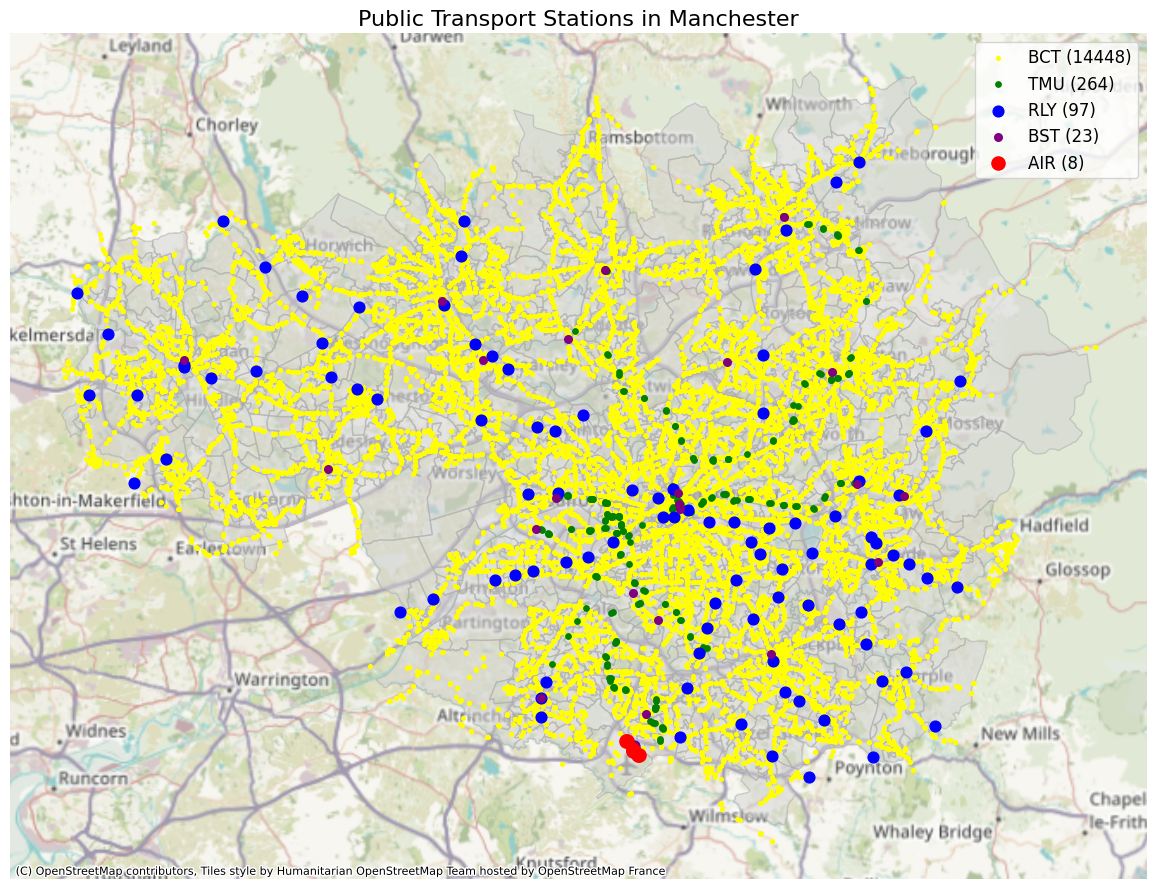

In [14]:
# Perform spatial visualization of the loaded bus stop data to verify correct processing
fig, ax = plt.subplots(1, figsize=(15, 9))

# Set the color mapping
colors = {'BCT': 'yellow','TMU': 'green','RLY': 'blue','BST': 'purple','AIR': 'red'}

# Plot LSOA boundaries as base map
gm_lsoa.plot(ax=ax, color='lightgrey', edgecolor='darkgrey', alpha=0.5)

# Group by stop type and plot
for stop_type, color in colors.items():
    if stop_type in final_stops['StopType'].values:
        subset = final_stops[final_stops['StopType'] == stop_type]
        subset.plot(ax=ax, color=color, marker='o',
                   label=f"{stop_type} ({len(subset)})",
                   markersize=90 if stop_type == 'AIR' else
                              60 if stop_type == 'RLY' else
                              15 if stop_type == 'TMU' else
                              30 if stop_type == 'BST' else 7)

ctx.add_basemap(ax, crs=gm_lsoa.crs.to_string())

ax.legend(fontsize=12)
ax.set_title('Public Transport Stations in Manchester', fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.show()

After processing and visualizing the bus stop data, it can be observed that the bus stop locations are evenly distributed throughout the Greater Manchester metropolitan area and conform to the road network distribution pattern, indicating successful data import and cleaning.

However, in the categorized data, eight points are shown as airports, despite Manchester having only one airport. Therefore, the CommonName field is used to examine why this situation has occurred.

In [15]:
# Filter stops with StopType 'AIR'
air_stops = final_stops[final_stops['StopType'] == 'AIR']
display(air_stops['CommonName'])

114395      Terminal One Access
114396      Terminal One Access
114397      Terminal One Access
114398      Terminal One Access
114399    Terminal Three Access
114400    Terminal Three Access
114401      Terminal Two Access
114402      Terminal Two Access
Name: CommonName, dtype: object

It can be observed that these eight points with the "AIR" type do not all represent different airports, but rather different terminal entrances for the same airport. To avoid incorrect influence on subsequent modeling, these eight points need to be consolidated into a single point.

In [16]:
# Filter airport stops
airport_terminals = final_stops[final_stops['StopType'] == 'AIR']

# Calculate the center point of airport stops
airport_center = airport_terminals.geometry.union_all().centroid

# Remove all airport stops from the data
final_stops = final_stops[final_stops['StopType'] != 'AIR']

# Create a new airport center point record
# Get the columns from the original data to ensure the new record has the same column structure
columns = final_stops.columns.tolist()

# Create a new airport record, filling data according to the column structure
new_airport = {}
for col in columns:
    if col == 'CommonName':
        new_airport[col] = 'Manchester Airport'
    elif col == 'StopType':
        new_airport[col] = 'AIR'
    elif col == 'geometry':
        continue  # geometry will be added through the GeoDataFrame constructor
    else:
        # Use default values or get values from original airport data for other columns
        if len(airport_terminals) > 0 and col in airport_terminals.columns:
            new_airport[col] = airport_terminals.iloc[0][col]
        else:
            new_airport[col] = None

# Create a new airport center point GeoDataFrame
airport_point = gpd.GeoDataFrame([new_airport], geometry=[airport_center], crs=final_stops.crs)

# Add the new airport point to the original data
final_stops = pd.concat([final_stops, airport_point])

# Reset the index
final_stops = final_stops.reset_index(drop=True)

# Print the count of each stop type
print(final_stops['StopType'].value_counts())

StopType
BCT    14448
TMU      264
RLY       97
BST       23
AIR        1
Name: count, dtype: int64


It can be observed that the airport terminals have been consolidated into a single central point. At this stage, data import, cleaning, and filtering have been completed. The next step is to begin modeling.

##Modeling

In spatial analysis of housing prices and transportation accessibility, the Geographically Weighted Regression (GWR) method is superior to traditional global regression models as it captures spatial variability and local relationships. Traditional linear regression assumes that variable relationships remain constant throughout the study area, ignoring spatial heterogeneity which is particularly evident in urban environments. As described by Fotheringham et al. <a href="https://www.wiley.com/en-us/Geographically+Weighted+Regression%3A+The+Analysis+of+Spatially+Varying+Relationships-p-9780471496168">[3]</a>, GWR allows regression coefficients to vary spatially, thus revealing unique patterns of house price-transportation accessibility relationships in different regions. Additionally, research by Lu et al. <a href="https://www.tandfonline.com/doi/full/10.1080/13658816.2013.865739">[4]</a> demonstrates that in real estate value analysis, GWR models significantly outperform global regression models in explanatory power and prediction accuracy, better capturing the influence of local market characteristics. Given the spatial heterogeneity in socioeconomic conditions and urban morphology across the Greater Manchester metropolitan area, GWR is the ideal method for exploring the spatial relationship between house prices and transportation accessibility in this study.

In [17]:
# Import additional necessary libraries for GWR analysis
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Data preparation: extract x and y coordinates from geometry
hp_man['x'] = hp_man.geometry.x
hp_man['y'] = hp_man.geometry.y
final_stops['x'] = final_stops.geometry.x
final_stops['y'] = final_stops.geometry.y

In public transportation accessibility analysis, different types of transit facilities typically exert varying degrees of influence on housing prices. The weighting scheme adopted in this study is based on the service coverage, frequency, and connectivity characteristics of transit nodes, assigning higher weights to airports (5.0) and railway stations (3.0), while lower weights are given to regular bus stops (0.5-1.0). This hierarchical weighting approach is supported by research. For instance, Mohammad et al. <a href="https://doi.org/10.1016/j.tra.2013.01.013">[5]</a> demonstrated that rail transit stations have significantly greater impact on housing prices than conventional bus stops. Similarly, Debrezion et al. <a href="https://doi.org/10.1111/j.1467-9787.2007.00517.x">[6]</a> found through meta-analysis that the influence radius of railway stations on property values can be 3-4 times that of regular bus stops. These research findings provide an empirical foundation for the transit stop weighting scheme in this study.

In [18]:
# Assign weights based on stop type
stop_type_weights = {
    'BCT': 0.5,      # Bus stops
    'BST': 1.0,      # Bus stations/hubs
    'TMU': 1.5,      # Tram/Metro stations
    'RLY': 3.0,      # Railway stations
    'AIR': 5.0,      # Airport
    # Add other stop types and their weights
}

# Add weights to the final_stops dataframe
final_stops['weight'] = final_stops['StopType'].map(lambda x: stop_type_weights.get(x, 1.0))

In determining the spatial extent of transportation stops' influence on housing prices, selecting appropriate walking distance thresholds is critical. Research indicates that the distance people are willing to walk to public transport stops varies by transport type. According to studies by Hess <a href="https://doi.org/10.5198/jtlu.v2i1.67">[7]</a>, urban planners typically use 400 meters (0.25 miles) and 800 meters (0.5 miles) as rule-of-thumb standards for evaluating how far people will walk to transit stops.

Furthermore, Transport for London's "Assessing Transport Connectivity" report confirms that in London, people typically walk up to 640 meters (approximately 8 minutes) to bus services and up to 960 meters (12 minutes) to rail or tube services <a href="https://content.tfl.gov.uk/connectivity-assessment-guide.pdf">[8]</a>.

Based on these research findings and practical standards, this study selects 400 meters and 800 meters as two analytical radii to compare the differential impact of transit stops on housing prices across different distance ranges. These two thresholds not only conform to academic research standards but also reflect actual walking behavior patterns.

In [19]:
# Add weighted public transit accessibility features for each house price point
def add_transit_features_weighted(hp_df, stops_df, buffer_distances=[400, 800]):
    """Calculate public transit accessibility indicators weighted by stop type"""
    # Build KD-tree
    stops_coords = stops_df[['x', 'y']].values
    tree = KDTree(stops_coords)

    # Calculate distance and type to the nearest transit stop for each house
    house_coords = hp_df[['x', 'y']].values
    distances, indices = tree.query(house_coords, k=1)
    hp_df['nearest_stop_dist'] = distances.flatten()

    # Add nearest stop type and its weight
    hp_df['nearest_stop_type'] = stops_df.iloc[indices.flatten()]['StopType'].values
    hp_df['nearest_stop_weight'] = stops_df.iloc[indices.flatten()]['weight'].values

    # Calculate weighted distance (distance divided by weight, making "effective distance" shorter for important stops)
    hp_df['weighted_nearest_dist'] = hp_df['nearest_stop_dist'] / hp_df['nearest_stop_weight']

    # Check actual stop types in the dataset
    existing_stop_types = stops_df['StopType'].unique()

    # Calculate weighted stop metrics within buffer zones
    for dist in buffer_distances:
        # Regular count
        counts = []
        # Weighted count
        weighted_counts = []

        # Counts by stop type
        type_counts = {}
        for type_key in existing_stop_types:  # Only count types that actually exist
            type_counts[f'stops_{type_key}_within_{dist}m'] = []

        for idx, coord in enumerate(house_coords):
            # Find all stops within the buffer zone
            idx_array = tree.query_radius([coord], r=dist)[0]

            # Calculate regular count
            counts.append(len(idx_array))

            # Calculate weighted count
            if len(idx_array) > 0:
                stop_weights = stops_df.iloc[idx_array]['weight'].values
                weighted_counts.append(np.sum(stop_weights))
            else:
                weighted_counts.append(0)

            # Count by stop type
            for type_key in existing_stop_types:
                if len(idx_array) > 0:
                    type_mask = stops_df.iloc[idx_array]['StopType'] == type_key
                    type_count = np.sum(type_mask)
                else:
                    type_count = 0
                type_counts[f'stops_{type_key}_within_{dist}m'].append(type_count)

        # Add to dataframe
        hp_df[f'stops_within_{dist}m'] = counts
        hp_df[f'weighted_stops_within_{dist}m'] = weighted_counts

        # Add counts by type
        for type_key, type_count_list in type_counts.items():
            hp_df[type_key] = type_count_list

    return hp_df

# Apply feature extraction
hp_man_with_features = add_transit_features_weighted(hp_man.copy(), final_stops)

# Moving window regression analysis
def moving_window_regression(df, x_vars, y_var, coords_cols=['x', 'y'], window_size=200):
    """Perform local regression analysis using a moving window"""
    n_points = len(df)
    n_vars = len(x_vars)

    # Pre-create fixed-size result arrays
    window_x = np.full(n_points, np.nan)
    window_y = np.full(n_points, np.nan)
    r2_values = np.full(n_points, np.nan)

    # Create coefficient and significance arrays for each variable
    coef_arrays = {f'coef_{var}': np.full(n_points, np.nan) for var in x_vars}
    sig_arrays = {f'sig_{var}': np.full(n_points, np.nan) for var in x_vars}

    # Extract coordinates
    coords = df[coords_cols].values

    # Find neighbors for each point
    tree = KDTree(coords)
    _, neighbors = tree.query(coords, k=window_size+1)

    # Standardize features
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[x_vars] = scaler.fit_transform(df[x_vars])

    # Perform local regression for each point
    for i in range(n_points):
        # Record coordinates
        window_x[i] = df[coords_cols[0]].iloc[i]
        window_y[i] = df[coords_cols[1]].iloc[i]

        # Get neighbor indices
        neighbor_indices = neighbors[i, 1:]  # Exclude self

        # Check if there are enough neighbors
        if len(neighbor_indices) <= n_vars + 1:
            # Too few neighbors to fit model, skip
            continue

        # Extract local data
        local_X = df_scaled.iloc[neighbor_indices][x_vars]
        local_y = df_scaled.iloc[neighbor_indices][y_var]

        # Run OLS regression
        X_with_const = sm.add_constant(local_X)
        model = sm.OLS(local_y, X_with_const)
        reg_results = model.fit()

        # Record results
        r2_values[i] = reg_results.rsquared

        for j, var in enumerate(x_vars):
            coef_arrays[f'coef_{var}'][i] = reg_results.params[j+1]  # +1 to skip constant term
            sig_arrays[f'sig_{var}'][i] = reg_results.pvalues[j+1] < 0.05

    # Combine all results into a dataframe
    results = {
        'window_x': window_x,
        'window_y': window_y,
        'r2': r2_values
    }
    results.update(coef_arrays)
    results.update(sig_arrays)

    # Convert to DataFrame
    return pd.DataFrame(results)

# Define feature variables
X_vars_weighted = [
    'weighted_nearest_dist',
    'weighted_stops_within_400m',
    'weighted_stops_within_800m'
]

y_var = 'Price'  # House price variable

# Use all data for moving window regression
# Window size set to 10% of total sample size or at least 30 points
window_size = max(30, int(len(hp_man_with_features) * 0.1))

# Run moving window regression
local_results_weighted = moving_window_regression(
    hp_man_with_features,
    X_vars_weighted,
    y_var,
    window_size=window_size
)

# Global model for reference
X_global = hp_man_with_features[X_vars_weighted]
X_global = sm.add_constant(X_global)
y_global = hp_man_with_features[y_var]
global_model_weighted = sm.OLS(y_global, X_global).fit()

print(global_model_weighted.summary())
# Output model performance metrics
print(f"\nGlobal R²: {global_model_weighted.rsquared:.4f}")
print(f"Local R² Mean: {local_results_weighted['r2'].dropna().mean():.4f}")
print(f"Local R² Range: {local_results_weighted['r2'].min():.4f} - {local_results_weighted['r2'].max():.4f}")

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     77.80
Date:                Tue, 20 May 2025   Prob (F-statistic):           4.47e-49
Time:                        03:35:09   Log-Likelihood:                -61783.
No. Observations:                4566   AIC:                         1.236e+05
Df Residuals:                    4562   BIC:                         1.236e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

The model results show that the global OLS regression has an R² value of 0.0487, indicating that transportation accessibility variables explain only about 4.9% of house price variance. Notably, the weighted count of stops within an 800m radius has a significant negative impact on house prices (p<0.001). In contrast, local regression yields a mean R² of 0.0948, reaching as high as 0.2369, suggesting substantial spatial variation in the relationship between house prices and transit accessibility. This spatial heterogeneity requires further exploration through more detailed visualization analysis.

##**Data** **Visualisation**
---



##Non-Spatial

**Non-spatial Visualization Choice: Violin Plot**

This study employs violin plots to display GWR coefficient distributions, as they simultaneously reveal data density, distribution shapes, and outliers <a href="https://doi.org/10.1080/00031305.1998.10480559">[9]</a>. Compared to box plots, violin plots more comprehensively illustrate multi-modal distribution characteristics of coefficients, which is crucial for understanding the spatial heterogeneity of transportation accessibility impacts. Additionally, the violin plots utilize a colorblind-friendly palette to ensure visualization accessibility <a href="https://doi.org/10.1038/s41467-020-19160-7">[10]</a>.

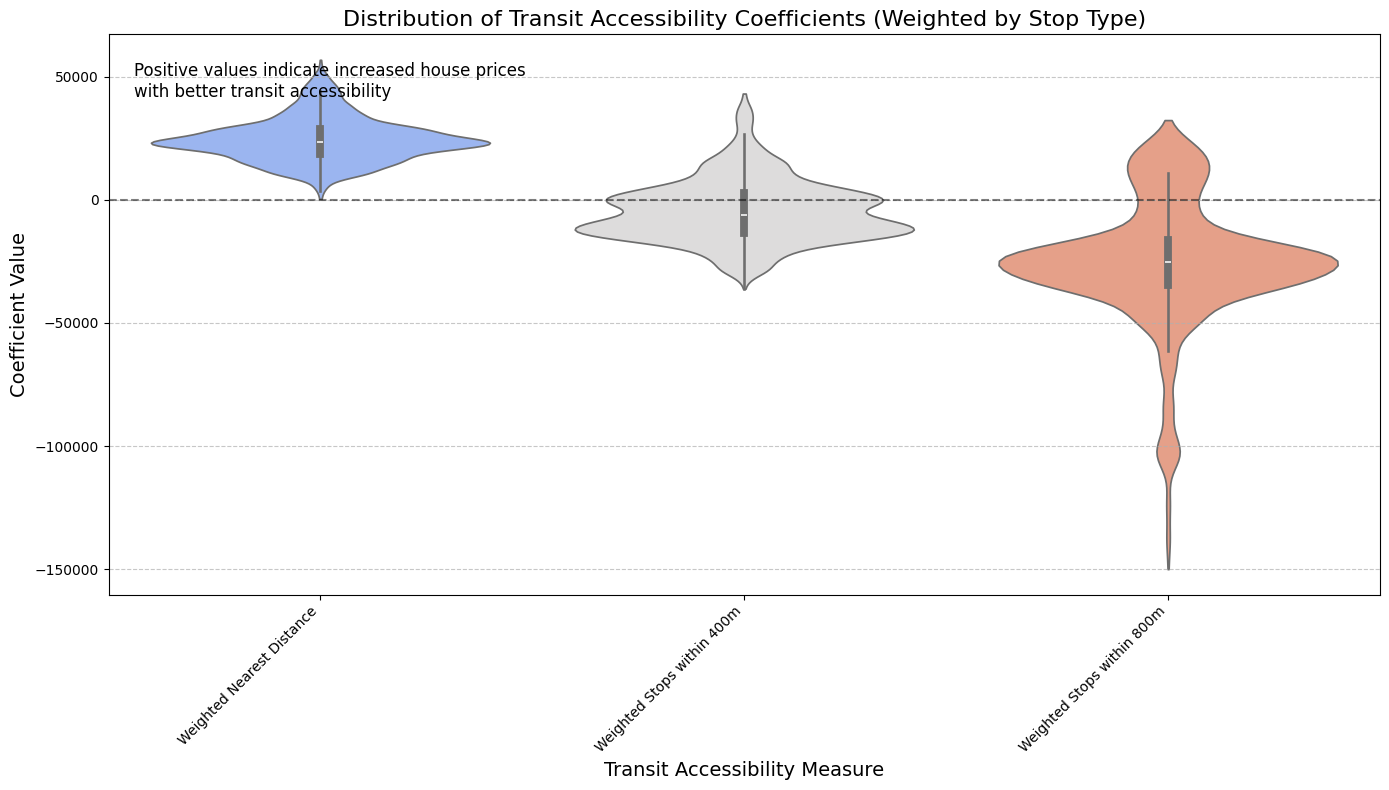

In [20]:
# Set plotting style
sns.set_palette('colorblind')  # Use a colorblind-friendly color scheme

# Violin plot of coefficient distributions
plt.figure(figsize=(14, 8))

# Prepare data
coef_data = pd.DataFrame({
    'Weighted Nearest Distance': local_results_weighted['coef_weighted_nearest_dist'].dropna(),
    'Weighted Stops within 400m': local_results_weighted['coef_weighted_stops_within_400m'].dropna(),
    'Weighted Stops within 800m': local_results_weighted['coef_weighted_stops_within_800m'].dropna()
})

# Also add railway and tram station variables if they exist in the data
if 'coef_stops_RLY_within_400m' in local_results_weighted.columns:
    coef_data['Railway Stations within 400m'] = local_results_weighted['coef_stops_RLY_within_400m'].dropna()
if 'coef_stops_TMU_within_400m' in local_results_weighted.columns:
    coef_data['Tram Stations within 400m'] = local_results_weighted['coef_stops_TMU_within_400m'].dropna()

# Convert to long format
coef_data_long = pd.melt(coef_data, var_name='Accessibility Measure', value_name='Coefficient Value')

# Create violin plot
ax = sns.violinplot(x='Accessibility Measure', y='Coefficient Value', data=coef_data_long, palette='coolwarm', cut=0)
plt.title('Distribution of Transit Accessibility Coefficients (Weighted by Stop Type)', fontsize=16)
plt.ylabel('Coefficient Value', fontsize=14)
plt.xlabel('Transit Accessibility Measure', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.text(0.02, 0.95, 'Positive values indicate increased house prices\nwith better transit accessibility',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('violin_plot_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

The violin plot results demonstrate significant spatial variability in how transportation accessibility influences house prices. The weighted nearest distance coefficients span both positive and negative values, indicating that convenient transportation elevates house prices in some areas while decreasing them in others. This aligns with findings by Mulley et al. <a href="https://doi.org/10.1016/j.tranpol.2017.09.005">[11]</a>, who noted that the relationship between transit convenience and house prices is moderated by regional socioeconomic and urban morphological factors.

**Model Performance Visualization: Histogram and Scatter Plot**

This study employs a combination of histogram and scatter plot to analyze model performance, as this pairing simultaneously illustrates the overall distribution of local R² values and their correlation with key variables . The histogram clearly presents the comparison between local and global model goodness-of-fit, while the scatter plot reveals potential relationship patterns between model performance and variable coefficients. This visualization utilizes the viridis color mapping, which maintains identifiability across various visual conditions.

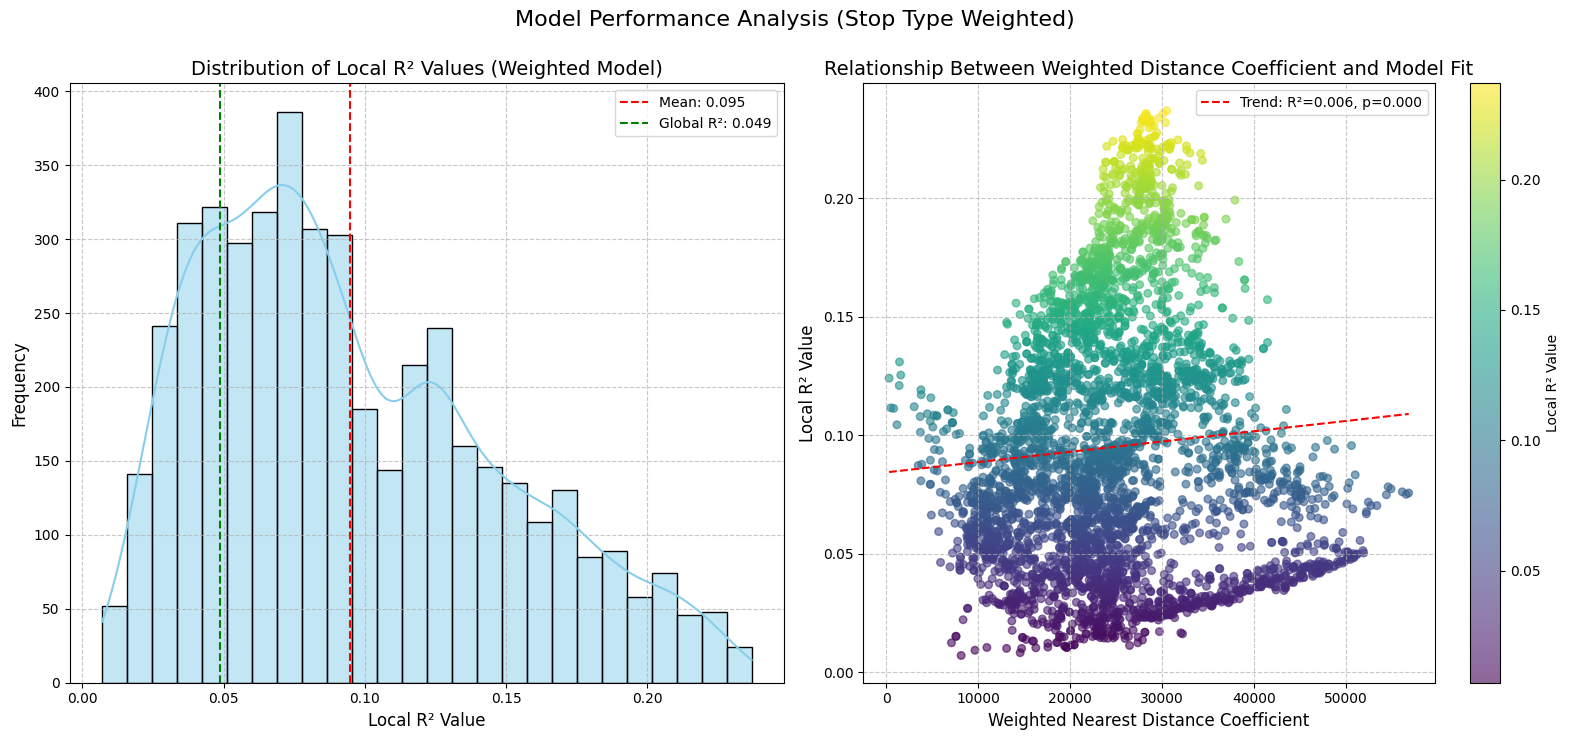

In [21]:
# Model Performance Analysis: R² Distribution and Coefficient Relationship
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# R² Distribution Histogram
valid_r2 = local_results_weighted['r2'].dropna()
sns.histplot(valid_r2, kde=True, ax=ax1, color='skyblue')
ax1.set_title('Distribution of Local R² Values (Weighted Model)', fontsize=14)
ax1.set_xlabel('Local R² Value', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.axvline(x=valid_r2.mean(), color='red', linestyle='--', label=f'Mean: {valid_r2.mean():.3f}')
ax1.axvline(x=global_model_weighted.rsquared, color='green', linestyle='--',
            label=f'Global R²: {global_model_weighted.rsquared:.3f}')
ax1.legend()
ax1.grid(linestyle='--', alpha=0.7)

# Relationship Scatter Plot: Weighted Nearest Stop Distance Coefficient vs. R²
cmap = plt.cm.viridis
sc = ax2.scatter(
    local_results_weighted['coef_weighted_nearest_dist'],
    local_results_weighted['r2'],
    c=local_results_weighted['r2'],
    cmap=cmap,
    alpha=0.6,
    s=30
)
ax2.set_title('Relationship Between Weighted Distance Coefficient and Model Fit', fontsize=14)
ax2.set_xlabel('Weighted Nearest Distance Coefficient', fontsize=12)
ax2.set_ylabel('Local R² Value', fontsize=12)
ax2.grid(linestyle='--', alpha=0.7)
plt.colorbar(sc, ax=ax2, label='Local R² Value')

# Add trend line
from scipy import stats
mask = ~np.isnan(local_results_weighted['coef_weighted_nearest_dist']) & ~np.isnan(local_results_weighted['r2'])
if sum(mask) > 2:  # Ensure there are enough valid data points
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        local_results_weighted['coef_weighted_nearest_dist'][mask],
        local_results_weighted['r2'][mask]
    )
    x = np.array([local_results_weighted['coef_weighted_nearest_dist'][mask].min(),
                local_results_weighted['coef_weighted_nearest_dist'][mask].max()])
    ax2.plot(x, intercept + slope * x, 'r--',
            label=f'Trend: R²={r_value**2:.3f}, p={p_value:.3f}')
    ax2.legend()

plt.tight_layout()
plt.suptitle('Model Performance Analysis (Stop Type Weighted)', fontsize=16, y=1.05)
plt.savefig('model_performance_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

The chart analysis shows local R² values exhibiting a bimodal distribution, with the mean value (0.095) significantly higher than the global model (0.049), indicating that the GWR method better captures the spatial complexity of house price-transportation accessibility relationships than global regression. The scatter plot reveals a slight positive correlation between weighted distance coefficients and model fit (R²=0.006, p<0.001), which, despite being statistically significant, demonstrates only a weak relationship.

##Spatial

**Spatial Visualization: Coefficient Distribution Map**

This study employs choropleth mapping to visualize the spatial distribution of weighted nearest stop distance coefficients across Greater Manchester. This approach is particularly effective for revealing geographic patterns in GWR coefficients <a href="https://doi.org/10.1179/000870406X114658">[12]</a>. The coolwarm color scheme was selected for its perceptual linearity and colorblind-friendly properties, while CartoDB Positron was chosen as the basemap to provide geographic context without overwhelming the thematic data. The visualization is designed for urban planners and transportation policymakers, using clear boundary delineation and intuitive color coding.

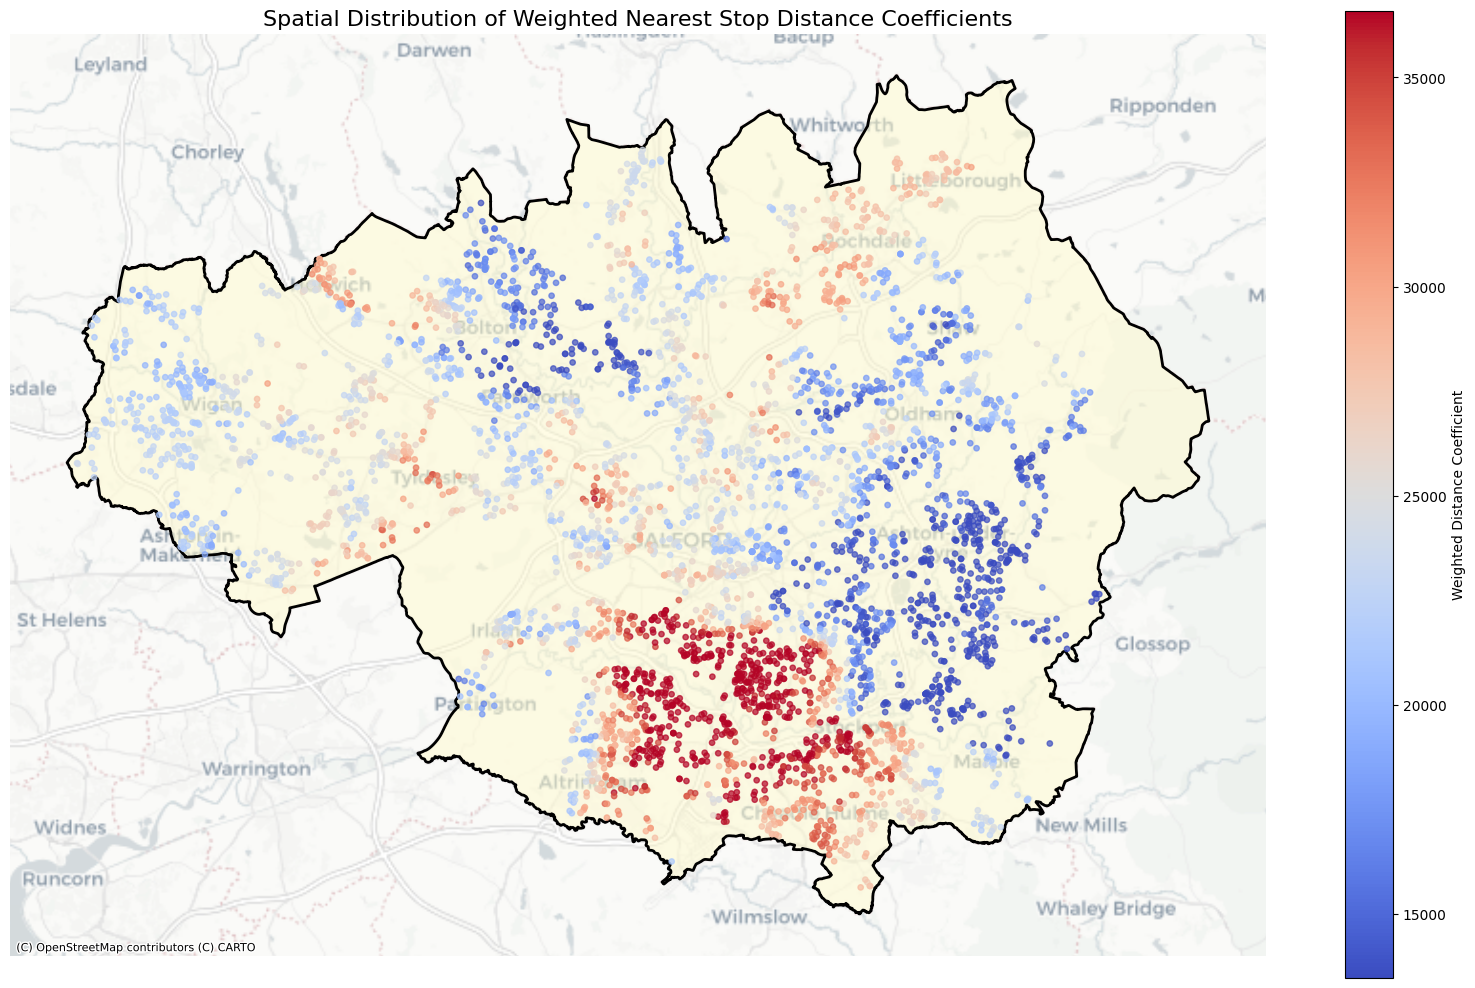

In [22]:
#!pip install contextily
# Import necessary libraries
import contextily as ctx
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Convert local regression results to GeoDataFrame for spatial visualization
local_results_geo = gpd.GeoDataFrame(
   local_results_weighted,
   geometry=gpd.points_from_xy(local_results_weighted.window_x, local_results_weighted.window_y),
   crs=hp_man.crs
)

# Merge LSOA data into a Manchester boundary outline
manchester_boundary = gm_lsoa.unary_union
manchester_boundary = gpd.GeoDataFrame(geometry=[manchester_boundary], crs=gm_lsoa.crs)

# Convert data to Web Mercator projection
local_results_web = local_results_geo.to_crs(epsg=3857)
hp_man_web = hp_man.to_crs(epsg=3857)
final_stops_web = final_stops.to_crs(epsg=3857)
manchester_boundary_web = manchester_boundary.to_crs(epsg=3857)

# Add Manchester boundary to visualization
plt.figure(figsize=(16, 10))
vmin = local_results_geo['coef_weighted_nearest_dist'].quantile(0.1)
vmax = local_results_geo['coef_weighted_nearest_dist'].quantile(0.9)

ax = plt.subplot(111)
manchester_boundary_web.plot(ax=ax, color='#FFFACD', alpha=0.5, zorder=1)
# First draw Manchester boundary
manchester_boundary_web.boundary.plot(ax=ax, color='black', linewidth=2, zorder=1)

# Plot point data
local_results_web.plot(
   column='coef_weighted_nearest_dist',
   cmap='coolwarm',
   ax=ax,
   markersize=15,
   alpha=0.7,
   vmin=vmin,
   vmax=vmax,
   legend=True,
   legend_kwds={'label': 'Weighted Distance Coefficient'},
   zorder=2
)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add title and labels
plt.title('Spatial Distribution of Weighted Nearest Stop Distance Coefficients', fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('spatial_weighted_distance.png', dpi=300, bbox_inches='tight')
plt.show()

The map reveals striking spatial heterogeneity in how transport accessibility influences house prices across Greater Manchester. The southern areas, particularly around Stockport, Altrincham, and Cheadle, display strong positive coefficients (red), indicating that proximity to weighted transit stops significantly increases property values. In contrast, northeastern districts including Oldham and parts of Rochdale show predominantly negative coefficients (blue), suggesting that transportation accessibility may be associated with lower property values in these areas. This spatial pattern aligns with Banister's <a href="https://doi.org/10.1016/j.tranpol.2007.10.005">[13]</a> findings that transport infrastructure's impact varies considerably based on local socioeconomic conditions and existing urban development patterns.

**Spatial Visualization: Model Performance Map**

This study employs a point-based choropleth map to visualize the spatial distribution of local R² values across Greater Manchester. This visualization technique effectively captures the geographic variation in model performance while maintaining the discrete nature of the data points <a href="https://www.tandfonline.com/doi/abs/10.1179/000870406X114658">[14]</a>. The viridis color scheme was selected for its perceptual uniformity, sequential clarity, and color-blindness accessibility <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0199239">[15]</a>. The CartoDB Positron basemap provides subtle geographic context while ensuring the thematic data remains the focal point. This visualization targets urban planners and housing market analysts, enabling them to identify areas where transportation accessibility most strongly explains housing price variation.

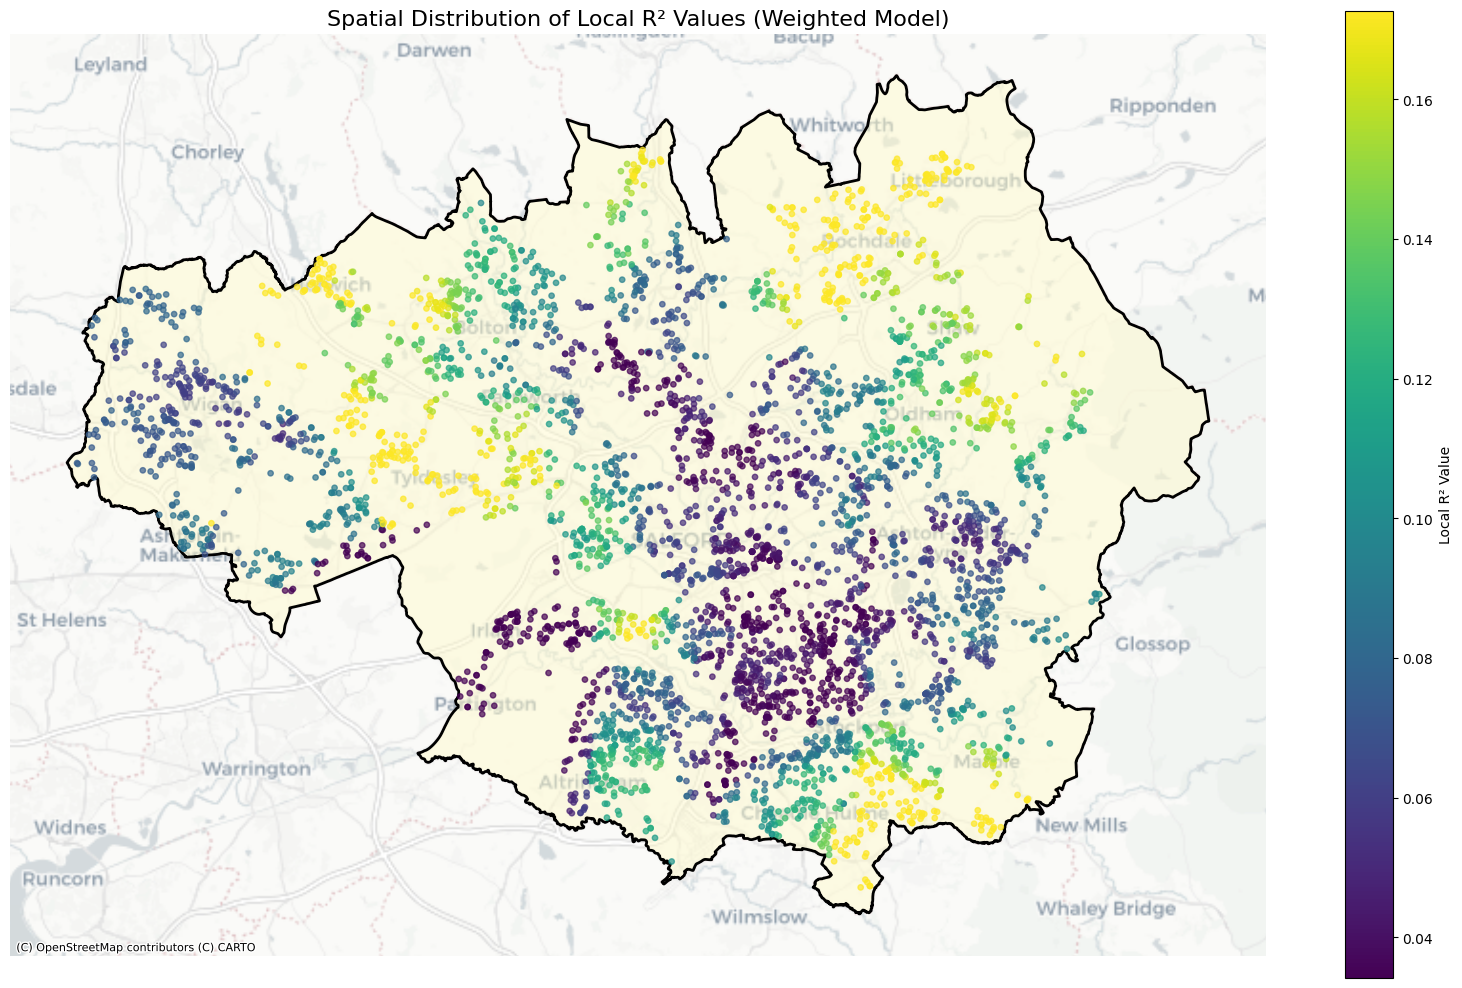

In [23]:
# Spatial distribution of local R²
plt.figure(figsize=(16, 10))
vmin = max(0, local_results_geo['r2'].quantile(0.1))
vmax = min(0.3, local_results_geo['r2'].quantile(0.9))

ax = plt.subplot(111)

# Plot Manchester boundary area
manchester_boundary_web.plot(ax=ax, color='#FFFACD', alpha=0.5, zorder=1)
manchester_boundary_web.boundary.plot(ax=ax, color='black', linewidth=2, zorder=2)

# Plot point data
local_results_web.plot(
    column='r2',
    cmap='viridis',
    ax=ax,
    markersize=15,
    alpha=0.7,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'label': 'Local R² Value'},
    zorder=2
)

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Add title
plt.title('Spatial Distribution of Local R² Values (Weighted Model)', fontsize=16)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('spatial_r2_weighted.png', dpi=300, bbox_inches='tight')
plt.show()

The map reveals a complex spatial pattern of model performance across Greater Manchester. Northeastern areas, particularly around Rochdale and parts of Bury, exhibit higher R² values (yellow/green), indicating locations where transportation accessibility metrics more effectively explain housing price variations. In contrast, central Manchester and parts of southern districts show notably lower model performance (purple/blue). This pattern suggests that in urban core areas, other factors beyond transportation accessibility likely play more dominant roles in determining house prices, such as proximity to employment centers, educational facilities, or amenities. These findings align with Ahlfeldt et al.'s <a href="https://doi.org/10.3982/ECTA10876">[16]</a>. research demonstrating that the explanatory power of accessibility variables diminishes in areas with high concentrations of other urban amenities.

## References
<p><a href="https://www.whatdotheyknow.com/request/algorithm_for_computing_postcode">[1]</a>Algorithm for Computing Postcode Centroids in Code-Point Open</p>
<p><a href="https://pmc.ncbi.nlm.nih.gov/articles/PMC2266732/">[2]</a>Henry KA, Boscoe FP. Estimating the accuracy of geographical imputation. Int J Health Geogr. 2008 Jan 23;7:3. doi: 10.1186/1476-072X-7-3. PMID: 18215308; PMCID: PMC2266732.</p>
<p><a href="https://www.perlego.com/book/2760594/geographically-weighted-regression-the-analysis-of-spatially-varying-relationships-pdf">[3]</a>A. Stewart Fotheringham, C. B. (2003). Geographically Weighted Regression : The Analysis of Spatially Varying Relationships. Wiley.
</p>
<p><a href="https://www.tandfonline.com/doi/full/10.1080/13658816.2013.865739?scroll=top&needAccess=true">[4]</a>Lu, B., Charlton, M., Harris, P., & Fotheringham, A. S. (2014). Geographically weighted regression with a non-Euclidean distance metric: a case study using hedonic house price data. International Journal of Geographical Information Science, 28(4), 660–681. https://doi.org/10.1080/13658816.2013.865739
</p>
<p><a href="https://www.sciencedirect.com/science/article/pii/S0965856413000207?via%3Dihub">[5]</a>Mohammad, S. I., Graham, D. J., Melo, P. C., & Anderson, R. J. (2013). A meta-analysis of the impact of rail projects on land and property values. Transportation Research. Part A, Policy and Practice, 50, 158–170. https://doi.org/10.1016/j.tra.2013.01.013
</p>
<p><a href="https://www.proquest.com/docview/203149364?pq-origsite=primo&accountid=14664&sourcetype=Scholarly%20Journals">[6]</a>Debrezion, G., Pels, E., & Rietveld, P. (2007). The Impact of Railway Stations on Residential and Commercial Property Value: A Meta-analysis. The Journal of Real Estate Finance and Economics, 35(2), 161–180. https://doi.org/10.1007/s11146-007-9032-z
</p>
<p><a href="https://www.jstor.org/stable/26201621?seq=1">[7]</a>Hess, D. B. (2009). Access to Public Transit and Its Influence on Ridership for Older Adults in Two U.S. Cities. Journal of Transport and Land Use, 2(1), 3–27. https://doi.org/10.5198/jtlu.v2i1.11
</p>
<p><a href="https://content.tfl.gov.uk/connectivity-assessment-guide.pdf">[8]</a>Assessing transport connectivity in London</p>
<p><a href="https://www.tandfonline.com/doi/abs/10.1080/00031305.1998.10480559">[9]</a>Hintze, J. L., & Nelson, R. D. (1998). Violin Plots: A Box Plot-Density Trace Synergism. The American Statistician, 52(2), 181–184. https://doi.org/10.1080/00031305.1998.10480559</p>
<p><a href="https://www.nature.com/articles/s41467-020-19160-7">[10]</a>Crameri, F., Shephard, G. E., & Heron, P. J. (2020). The misuse of colour in science communication. Nature Communications, 11(1), 5444–10. https://doi.org/10.1038/s41467-020-19160-7</p>
<p><a href="https://www.sciencedirect.com/science/article/pii/S0967070X17300811?via%3Dihub">[11]</a>
  Bösch, P. M., Becker, F., Becker, H., & Axhausen, K. W. (2018). Cost-based analysis of autonomous mobility services. Transport Policy, 64, 76–91. https://doi.org/10.1016/j.tranpol.2017.09.005
</p>
<p><a href="https://www.tandfonline.com/doi/abs/10.1179/000870406X114658">[12]</a>Mennis, J. (2006). Mapping the Results of Geographically Weighted Regression. The Cartographic Journal, 43(2), 171–179. https://doi.org/10.1179/000870406X114658</p>
<p><a href="https://www.sciencedirect.com/science/article/pii/S0967070X07000820?via%3Dihub">[13]</a>Banister, D. (2008). The sustainable mobility paradigm. Transport Policy, 15(2), 73–80. https://doi.org/10.1016/j.tranpol.2007.10.005
</p>
<p><a href="https://www.tandfonline.com/doi/abs/10.1179/000870406X114658">[14]</a>Mennis, J. (2006). Mapping the Results of Geographically Weighted Regression. Cartographic Journal, 43(2), 171–179. https://doi.org/10.1179/000870406X114658
</p>
<p><a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0199239">[15]</a>Nuñez, J. R., Anderton, C. R., & Renslow, R. S. (2018). Optimizing colormaps with consideration for color vision deficiency to enable accurate interpretation of scientific data. PloS One, 13(7), e0199239–e0199239. https://doi.org/10.1371/journal.pone.0199239
</p>
<p><a href="https://www.econometricsociety.org/publications/econometrica/2015/11/01/economics-density-evidence-berlin-wall">[16]</a>Ahlfeldt, G. M., National Bureau of Economic Research., Redding, S. J., Sturm, D. M., & Wolf, N. (2014). The Economics of Density: Evidence from the Berlin Wall. National Bureau of Economic Research.
</p>